![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

# <a name="0">Machine Learning Accelerator - Tabular Data - Lecture 1</a>

## K Nearest Neighbors (KNN)

### Sample Problem: Detecting Products with Electrical Plugs in Amazon Marketplace Products

In this notebook, we build a [K Nearest Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to predict the __target_label__ field (plug or no plug) of the Amazon electric plug dataset.


1. <a href="#1">Read the datasets</a>
2. <a href="#2">Data Processing</a>
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a>
    * <a href="#23">Data Preprocessing (cleaning)</a>
    * <a href="#24">Train - Validation - Test Datasets</a>
    * <a href="#25">Data Processing with Pipeline</a>
3. <a href="#3">Train (and Tune) a Classifier</a>
4. <a href="#4">Test the Classifier</a>
5. <a href="#5">Improvement ideas</a>


__Dataset schema:__ 
- __ASIN__: Product ASIN
- __target_label:__ Binary field with values in {0,1}. A value of 1 show ASIN has a plug, otherwise 0.
- __ASIN_STATIC_ITEM_NAME:__ Title of the ASIN.
- __ASIN_STATIC_PRODUCT_DESCRIPTION:__ Description of the ASIN
- __ASIN_STATIC_GL_PRODUCT_GROUP_TYPE:__ GL information for the ASIN.
- __ASIN_STATIC_ITEM_PACKAGE_WEIGHT:__ Weight of the ASIN.
- __ASIN_STATIC_LIST_PRICE:__ Price information for the ASIN.
- __ASIN_STATIC_BATTERIES_INCLUDED:__ Information whether batteries are included along with the product.
- __ASIN_STATIC_BATTERIES_REQUIRED:__ Information whether batteries are required for using the product.
- __ASIN_STATIC_ITEM_CLASSIFICATION:__ Item classification of whether it is a standalone or bundle parent item etc


## 1. <a name="1">Read the datasets</a>
(<a href="#0">Go to top</a>)

Let's read the training and test data files into dataframes, using [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html).

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
  
df = pd.read_csv('../../data/review/asin_electrical_plug_training_data.csv')
test_data = pd.read_csv('../../data/review/asin_electrical_plug_test_data.csv')

print('The shape of the training dataset is:', df.shape)
print('The shape of the test dataset is:', test_data.shape)

The shape of the training dataset is: (55109, 10)
The shape of the test dataset is: (6124, 10)


## 2. <a name="2">Data Processing</a>
(<a href="#0">Go to top</a>)

### 2.1 <a name="21">Exploratory Data Analysis</a>
(<a href="#2">Go to Data Processing</a>)

We look at number of rows, columns, and some simple statistics of the training dataset.

In [2]:
# Print the first five rows
# NaN means missing data
df.head()

,ASIN,target_label,ASIN_STATIC_ITEM_NAME,ASIN_STATIC_PRODUCT_DESCRIPTION,ASIN_STATIC_GL_PRODUCT_GROUP_TYPE,ASIN_STATIC_ITEM_PACKAGE_WEIGHT,ASIN_STATIC_LIST_PRICE,ASIN_STATIC_BATTERIES_INCLUDED,ASIN_STATIC_BATTERIES_REQUIRED,ASIN_STATIC_ITEM_CLASSIFICATION
0,B000816IUC,0,Bruder 02921 Jeep Wrangler Unlimited with Hors...,NEW! Jeep Wrangler by Bruder with trailer come...,gl_toy,3.450000,36.66,False,False,base_product
1,B003674A1Y,0,"Lucky Reptile OV-2 OpenAir Vivarium, Medium",Größe: 40x40x60 cm. <p>Lucky Reptile OpenAir V...,gl_pet_products,2.690000,24.68,False,False,base_product
2,B007ECONV4,0,"Klarfit KS5DG Chin Up Bar (150kg Max Load, Doo...",<p><b>Highly flexible pull-up bar with six con...,gl_sports,8.112928,NaN,False,False,base_product
3,B00D89465A,0,Liverpool FC Stripe Wallpaper,This fantastic Liverpool Wallpaper is ideal fo...,gl_home,1.763680,8.33,NaN,NaN,base_product
4,B001MJ0BN4,0,Rolson 68889 Oil Tanned Double Tool Pouch,"Eleven pockets, two fixed metal hammer holders...",gl_biss,2.733704,27.38,NaN,NaN,base_product


In [3]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55109 entries, 0 to 55108
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ASIN                               55109 non-null  object 
 1   target_label                       55109 non-null  int64  
 2   ASIN_STATIC_ITEM_NAME              55109 non-null  object 
 3   ASIN_STATIC_PRODUCT_DESCRIPTION    31727 non-null  object 
 4   ASIN_STATIC_GL_PRODUCT_GROUP_TYPE  55109 non-null  object 
 5   ASIN_STATIC_ITEM_PACKAGE_WEIGHT    55027 non-null  float64
 6   ASIN_STATIC_LIST_PRICE             41182 non-null  float64
 7   ASIN_STATIC_BATTERIES_INCLUDED     45016 non-null  object 
 8   ASIN_STATIC_BATTERIES_REQUIRED     40688 non-null  object 
 9   ASIN_STATIC_ITEM_CLASSIFICATION    55097 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 4.6+ MB


In [4]:
# This prints basic statistics for numerical columns
df.describe()

,target_label,ASIN_STATIC_ITEM_PACKAGE_WEIGHT,ASIN_STATIC_LIST_PRICE
count,55109.000000,55027.000000,4.118200e+04
mean,0.036618,31.130529,1.563334e+02
std,0.187825,458.771422,1.754345e+04
min,0.000000,0.000000,1.160000e+00
25%,0.000000,1.520000,1.667000e+01
50%,0.000000,2.513244,3.268500e+01
75%,0.000000,5.555592,6.999000e+01
max,1.000000,29500.000000,3.560000e+06


#### Target distribution

Let's check our target distribution.

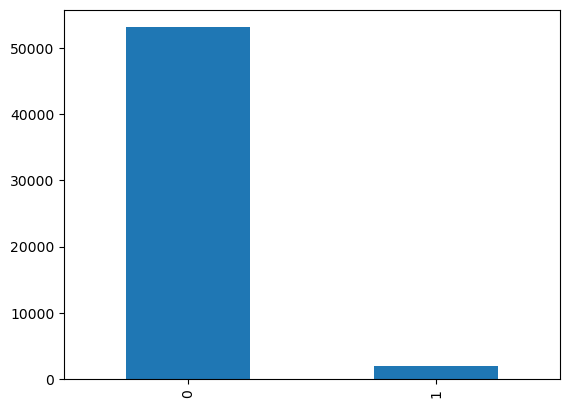

In [5]:
import matplotlib.pyplot as plt

df['target_label'].value_counts().plot.bar()
plt.show()

We notice that we are dealing with an imbalanced dataset. This means one result type is dominating the other one(s). In this case, we have a lot of class 0 ("no plug") records and very few class 1 ("plug") records. 

#### Dataset features

Let's now print the features of our dataset.

In [6]:
import numpy as np                    
np.set_printoptions(threshold=np.inf) # use this for datasets with more columns, to print all columns

# This prints the column labels of the dataframe
print('All dataset columns:')
print(df.columns.values)

# This prints the column labels of the features identified as numerical
print('Numerical columns:')
print(df.select_dtypes(include=np.number).columns.values)

# This prints the column labels of the features identified as numerical
print('Categorical columns:')
print(df.select_dtypes(include='object').columns.values)

All dataset columns:
['ASIN' 'target_label' 'ASIN_STATIC_ITEM_NAME'
 'ASIN_STATIC_PRODUCT_DESCRIPTION' 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE'
 'ASIN_STATIC_ITEM_PACKAGE_WEIGHT' 'ASIN_STATIC_LIST_PRICE'
 'ASIN_STATIC_BATTERIES_INCLUDED' 'ASIN_STATIC_BATTERIES_REQUIRED'
 'ASIN_STATIC_ITEM_CLASSIFICATION']
Numerical columns:
['target_label' 'ASIN_STATIC_ITEM_PACKAGE_WEIGHT' 'ASIN_STATIC_LIST_PRICE']
Categorical columns:
['ASIN' 'ASIN_STATIC_ITEM_NAME' 'ASIN_STATIC_PRODUCT_DESCRIPTION'
 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE' 'ASIN_STATIC_BATTERIES_INCLUDED'
 'ASIN_STATIC_BATTERIES_REQUIRED' 'ASIN_STATIC_ITEM_CLASSIFICATION']


### 2.2 <a name="22">Select features to build the model</a>
(<a href="#2">Go to Data Processing</a>)

We only consider the __numerical features__ to build a classifer for this first sample solution. The numerical features are: __ASIN_STATIC_ITEM_PACKAGE_WEIGHT__ and __ASIN_STATIC_LIST_PRICE__.

In [7]:
# Grab model features/inputs and target/output
numerical_features = ["ASIN_STATIC_ITEM_PACKAGE_WEIGHT",
                      "ASIN_STATIC_LIST_PRICE"]

model_features = numerical_features
model_target = 'target_label'

### 2.3 <a name="23">Data Preprocessing: Cleaning numerical features</a>
(<a href="#2">Go to Data Processing</a>)

Let's examine the numerical features.

In [8]:
for i in range(0,len(numerical_features)):
    print(df[numerical_features[i]].value_counts(bins=10, sort=False))

(-29.501, 2950.0]     54910
(2950.0, 5900.0]         50
(5900.0, 8850.0]         28
(8850.0, 11800.0]        19
(11800.0, 14750.0]        8
(14750.0, 17700.0]        7
(17700.0, 20650.0]        1
(20650.0, 23600.0]        0
(23600.0, 26550.0]        1
(26550.0, 29500.0]        3
Name: ASIN_STATIC_ITEM_PACKAGE_WEIGHT, dtype: int64
(-3558.84, 356001.044]        41181
(356001.044, 712000.928]          0
(712000.928, 1068000.812]         0
(1068000.812, 1424000.696]        0
(1424000.696, 1780000.58]         0
(1780000.58, 2136000.464]         0
(2136000.464, 2492000.348]        0
(2492000.348, 2848000.232]        0
(2848000.232, 3204000.116]        0
(3204000.116, 3560000.0]          1
Name: ASIN_STATIC_LIST_PRICE, dtype: int64


__Outliers__. We have an outlier data in the last bin of the second numerical feature. We will remove this data point below.

In [9]:
#print(df[df[numerical_features[1]] > 3000000])
dropIndexes = df[df[numerical_features[1]] > 3000000].index
df.drop(dropIndexes , inplace=True)

In [10]:
df[numerical_features[1]].value_counts(bins=10, sort=False)

(-13.838999999999999, 1500.944]    41147
(1500.944, 3000.728]                  15
(3000.728, 4500.512]                   8
(4500.512, 6000.296]                   3
(6000.296, 7500.08]                    2
(7500.08, 8999.864]                    3
(8999.864, 10499.648]                  0
(10499.648, 11999.432]                 1
(11999.432, 13499.216]                 0
(13499.216, 14999.0]                   2
Name: ASIN_STATIC_LIST_PRICE, dtype: int64

__Missing Values__. Let's check missing values for these numerical features.

In [11]:
print(df[numerical_features].isna().sum())

ASIN_STATIC_ITEM_PACKAGE_WEIGHT       82
ASIN_STATIC_LIST_PRICE             13927
dtype: int64


As a quick fix, we will apply mean imputation. This will replace the missing values with the mean value of the corresponding column.

__Note on imputation__: The statistically correct way to perform mean/mode imputation before training an ML model is to compute the column-wise means on the training data only, and then use these values to impute missing data in both the train and test sets. So, we'll need to split our dataset first.

### 2.4 <a name="24">Train - Validation - Test Datasets</a>
(<a href="#2">Go to Data Processing</a>)

We have already split the original dataset into two data files: __training__ data file (asin_electrical_plug_training_data.csv) with __90%__ of the samples and the __test__ data file (asin_electrical_plug_test_data.csv) with the remaining __10%__. We further split our training dataset into training and validation subsets using sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [12]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(df, test_size=0.15, shuffle=True, random_state=23)

# Print the shapes of the Train - Validation - Test Datasets
print('Train - Validation - Test Datasets shapes: ', train_data.shape, val_data.shape, test_data.shape)


Train - Validation - Test Datasets shapes:  (46841, 10) (8267, 10) (6124, 10)


### 2.5 <a name="25">Data processing with Pipeline</a>
(<a href="#2">Go to Data Processing</a>)

In a typical machine learning workflow you will need to apply data transformations, like imputation and scaling shown here, at least twice. First on the training dataset with __.fit()__ and __.transform()__, when preparing the data to training the model. And again, on any new data you want to predict on (validation or test), with __.transform()__. Sklearn's [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) is a tool that simplifies this process by enforcing the implementation and order of data processing steps. 

We build a pipeline to impute the missing values with the mean using sklearn's [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html), scale the numerical features to have similar orders of magnitude by bringing them into the 0-1 range with sklearn's [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), and finally train an estimator [K Nearest Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) on the imputed and scaled dataset. 


In [13]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

### PIPELINE ###
################

# Pipeline desired data transformers, along with an estimator at the end
# For each step specify: a name, the actual transformer/estimator with its parameters
classifier = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('estimator', KNeighborsClassifier(n_neighbors = 3))
])

# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
classifier

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('estimator', KNeighborsClassifier(n_neighbors=3))])

## 3. <a name="3">Train (and Tune) a Classifier</a>
(<a href="#0">Go to top</a>)

### Model Training

We train the classifier with __.fit()__ on our training dataset. 

In [14]:
# Get train data to train the classifier
X_train = train_data[model_features]
y_train = train_data[model_target]

# Fit the classifier to the train data
# Train data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to fit the model
classifier.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('estimator', KNeighborsClassifier(n_neighbors=3))])

Let's now evaluate the performance of the trained classifier, on the training and the validation datasets. We use __.predict()__ this time. 


In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Use the fitted model to make predictions on the train dataset
# Train data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to make predictions
train_predictions = classifier.predict(X_train)

print('Model performance on the train set:')
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Train accuracy:", accuracy_score(y_train, train_predictions))

Model performance on the train set:
[[44959   172]
 [ 1563   147]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     45131
           1       0.46      0.09      0.14      1710

    accuracy                           0.96     46841
   macro avg       0.71      0.54      0.56     46841
weighted avg       0.95      0.96      0.95     46841

Train accuracy: 0.9629598001750603


In [16]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get validation data to validate the classifier
X_val = val_data[model_features]
y_val = val_data[model_target]

# Use the fitted model to make predictions on the validation dataset
# Validation data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to make predictions
val_predictions = classifier.predict(X_val)

print('Model performance on the validation set:')
print(confusion_matrix(y_val, val_predictions))
print(classification_report(y_val, val_predictions))
print("Validation accuracy:", accuracy_score(y_val, val_predictions))

Model performance on the validation set:
[[7903   56]
 [ 303    5]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7959
           1       0.08      0.02      0.03       308

    accuracy                           0.96      8267
   macro avg       0.52      0.50      0.50      8267
weighted avg       0.93      0.96      0.94      8267

Validation accuracy: 0.9565743316801741


### Model Tuning

To optimize model performance, reducing the so-called *generalization gap* between performance metrics on the training and validation datasets, we could __tune__ the classifier using the __validation__ set. For example, we can try different values of $K$ and select the one producing the highest metric on the validation set.


In [17]:
# Try different values of K and select the one producing the highest metric on the validation set
# (later, we will see how do to this more efficiently with library hyperparameter tuning functions)

K_values = [1, 2, 3, 4, 5, 6]

K_best = 0.0
val_score_best = 0.0
for K in K_values:
    classifier = Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', MinMaxScaler()),
        ('estimator', KNeighborsClassifier(n_neighbors = K))
            ])
    classifier.fit(X_train, y_train)
    val_predictions = classifier.predict(X_val)
    val_acc = accuracy_score(y_val, val_predictions)
    print("K=%d, Validation accuracy: %f" % (K, val_acc))
    if val_acc > val_score_best:
        K_best = K
        val_score_best = val_acc
        
print("K_best=%d, Best Validation accuracy: %f" % (K_best, val_score_best))


K=1, Validation accuracy: 0.927180
K=2, Validation accuracy: 0.960566
K=3, Validation accuracy: 0.956574
K=4, Validation accuracy: 0.962260
K=5, Validation accuracy: 0.960808
K=6, Validation accuracy: 0.962622
K_best=6, Best Validation accuracy: 0.962622


In [18]:
# Finally, train the best model on the whole training dataset (df) again, before testing on the test dataset

# Get the best classifier
classifier = Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', MinMaxScaler()),
        ('estimator', KNeighborsClassifier(n_neighbors = K_best))
            ])

# Get training data to train the classifier once more
X_training = df[model_features]
y_training = df[model_target]

# Train the best classifier once more on all training dataset
classifier.fit(X_training, y_training)


Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('estimator', KNeighborsClassifier(n_neighbors=6))])

## 4. <a name="4">Test the Classifier</a>
(<a href="#0">Go to top</a>)

And now, let's evaluate the performance of the classifier on the test set.

Before that, let's first see how the model works on the training dataset.

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Use the fitted model to make predictions on the train dataset
train_predictions = classifier.predict(X_train)

print('Model performance on the train set:')
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Train accuracy:", accuracy_score(y_train, train_predictions))     

Model performance on the train set:
[[45128     3]
 [ 1708     2]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     45131
           1       0.40      0.00      0.00      1710

    accuracy                           0.96     46841
   macro avg       0.68      0.50      0.49     46841
weighted avg       0.94      0.96      0.95     46841

Train accuracy: 0.96347217181529


In [20]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get test data to test the classifier
X_test = test_data[model_features]
y_test = test_data[model_target]

# Use the fitted model to make predictions on the test dataset
# Test data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to make predictions
test_predictions = classifier.predict(X_test)

print('Model performance on the test set:')
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))
print("Test accuracy:", accuracy_score(y_test, test_predictions))

Model performance on the test set:
[[5898    0]
 [ 226    0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5898
           1       0.00      0.00      0.00       226

    accuracy                           0.96      6124
   macro avg       0.48      0.50      0.49      6124
weighted avg       0.93      0.96      0.94      6124

Test accuracy: 0.9630960156760288


The generalization gap has been reduced. 

__Note on accuracy__: We achieved good accuracy on our test dataset. This might seem like a good score, but the confusion matrix and classification report show poor performance identifying items with plug (class 1). Recall that our dataset is highly imbalanced, and therefore the accuracy score is heavily dominated by the non-plug samples. Accuracy can be a misleading metric. In the scenario that a different evaluation metric is chosen, that metric needs to be monitored when trying different values of $K$.

__Note on imbalanced dataset__: One way to address the imbalanced dataset is upsampling the rare the class, to have equal number of samples for each class. Remember to fix the imbalance only in training set without changing the validation and test sets, they should follow the original data distribution. 

## 5. <a name="5">Improvement Ideas</a>
(<a href="#0">Go to top</a>)

* Try target balancing by upsampling or downsampling (see slides, see 'Data Processing' notebook)
* Try different train-validation-test ratios, different values of K, different other KNN parameter choices
* Try different imputations and/or scaling choices
